In [1]:
import autograd

In [2]:
from ResComp import *
from sparse_specializer import *
from matplotlib import pyplot as plt
import networkx as nx
import copy
import random
import sys

plt.rcParams['figure.figsize'] = [10, 5]


BEGIN      = 0
END        = 60
TIMESTEPS  = 60000
X0         = [-20, 10, -.5]
FNAME      = "/Users/djpassey/Code/work/NetworkResearch/UVMproject/data/specRandNets/specNetw{}.csv"
NUM_SPECI  = 1042


In [3]:
plt.rcParams['figure.figsize'] = [10, 5]

In [4]:
def lorentz_deriv(t0, X, sigma=10., beta=8./3, rho=28.0):
    """Compute the time-derivative of a Lorenz system."""
    (x, y, z) = X
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]
# end

def lorenz_equ(x0=X0, begin=BEGIN, end=END, timesteps=TIMESTEPS):
    """Use solve_ivp to produce a solution to the lorenz equations""" 
    t = np.linspace(begin,end,timesteps)
    train_t = t[:len(t)//2]
    u = integrate.solve_ivp(lorentz_deriv, (begin,end),x0, dense_output=True).sol
    return t, train_t, u
# end

def toterror(u,pre):
    """Sum of ||u_i - pre_i||_2 for all i"""
    return np.sum(np.sum((u - pre)**2, axis=0)**.5)
# end

def msqerror(u,pre):
    """Mean squared error"""
    return np.mean(np.sum((u - pre)**2, axis=0)**.5)
# end

def maxdist(u,pre):
    """ Max over i of ||u_i - pre_i||"""
    return np.max(np.sum((u - pre)**2, axis=0)**.5)
# end

def load_spec(i):
    return np.genfromtxt(FNAME.format(i), delimiter=",")
# end

def config_model(A):
    """Produce a network with the same degree distribution as the 
        network with adj matrix A"""

    # Get in and out deg distributions
    G    = nx.DiGraph(A)
    din  = sorted([ d for n,d in G.in_degree()], reverse=True)
    dout = sorted([d for n,d in G.out_degree()], reverse=True)
    
    # Create new adj matrix
    M    = nx.directed_configuration_model(din,dout, create_using=nx.DiGraph)
    M    = nx.DiGraph(M) # Removes parellel edges
    M    = nx.adj_matrix(M).toarray()
    
    return M
# end

def score_nodes(rc, u, t, r_0=None):
    """ Give every node in the reservoir a relative importance score
        
        Parameters
        ----------
        rc (ResComp): reservoir computer
        u  (solve_ivp solution): system to model
        t  (ndarray): time values to test 
        
        Returns
        -------
        scores (ndarray): Each node's importance score
    """
    pre, r     = rc.predict(t, return_states=True, r_0=r_0)
    derivative = rc.W_out.T.dot(pre - u(t))
    scores     = np.mean(np.abs(derivative*r), axis=1)
    return scores
# end

def specialize_best_nodes(rc, how_many, u, t, r_0=None): 
    """ Specializes the most useful nodes in the reservoir and
        returns an adjacency matrix of the specialized reservoir
        
        Parameters
        ----------
        rc (ResComp): reservoir computer
        how_many (int): How many nodes to specialize
        u  (solve_ivp solution): system to model
        t  (ndarray): time values to test
        
        Returns
        S (ndarray): adj matrix of the specialized reservoir
        """
    scores     = score_nodes(rc, u, t, r_0=r_0)
    tot        = rc.res.shape[0]
    worst_idxs = list(np.argsort(scores)[1:(tot-how_many)])
    A          = rc.res
    for i in range(tot): A[i,i] = 0
    A          = (A != 0)*1
    S          = specializeGraph(A, worst_idxs)
    return S
# end   
    
def specialize_best_nodes_labeled(rc, how_many, u, t, r_0=None): 
    """ Specializes the most useful nodes in the reservoir and
        returns an adjacency matrix of the specialized reservoir
        
        Parameters
        ----------
        rc (ResComp): reservoir computer
        how_many (int): How many nodes to specialize
        u  (solve_ivp solution): system to model
        t  (ndarray): time values to test
        
        Returns
        S (ndarray): adj matrix of the specialized reservoir
        """
    scores     = score_nodes(rc, u, t, r_0=r_0)
    tot        = rc.res.shape[0]
    worst_idxs = list(np.argsort(scores)[1:(tot-how_many)])
    A          = rc.res
    for i in range(tot): A[i,i] = 0
    A          = (A != 0)*1
    S          = DirectedGraph(A, lambda x: x)
    S.specialize_graph(worst_idxs)
    return S
# end   

def how_long_accurate(u, pre, tol=1):
    """ Find the first i such that ||u_i - pre_i||_2 > tol """
    for i in range(u.shape[1]):
        dist = np.sum((u[:,i] - pre[:,i])**2)**.5
        if dist > tol:
            return i        
    return u.shape[1]
# end

def make_res_comp(A, params):
    # Make res comp with desired adj matrix A
    new_params = copy.deepcopy(params)
    m,n    = A.shape    
    new_params["res_sz"] = n
    rc     = ResComp(3,3, **new_params)
    rc.res = A * new_params["spect_rad"] / max(np.linalg.eigvals(A)).real
    return rc
# end

def best_node_idx(rc, scores, how_many):
    tot        = rc.res.shape[0]
    best_idxs  = list(np.argsort(scores)[-1*how_many:])
    return best_idxs
# end

def draw_orginal(rc, scores, how_many):
    n = rc.res.shape[0]
    G = nx.DiGraph(rc.res.T)
    best_nodes = best_node_idx(rc, scores, how_many)
    
    # Make color map
    colormap = ["#A0CBE2"] * n
    if how_many < 7:
        COLORS = "grcmyk"
        j= 0
        for i in best_nodes:
            colormap[i] = COLORS[j]
            j+=1
    else:
        for i in best_nodes:
            colormap[i] = np.random.rand(3)
        
    sizes = (scores - np.mean(scores))/np.std(scores)
    sizes = list(300*sizes + 300)

    return colormap, sizes, best_nodes, nx.draw(G, node_color=colormap, node_size=sizes)
# end

def draw_specialized(spec_rc, scores, specializer, orig_colors):
    n = spec_rc.res.shape[0]
    G = nx.DiGraph(spec_rc.res.T)
    
    # Make color map
    colormap = ["#A0CBE2"] * n
    for i in range(n):
        colormap[i] = orig_colors[specializer.origination(i)]
    # end
    
    sizes = (scores - np.mean(scores))/np.std(scores)
    sizes = list(300*sizes + 300)
    
    return colormap, sizes, nx.draw(G, node_color=colormap, node_size=sizes)
# end

### Solve system and train reservoir computer

In [9]:
params = {
    "diff_eq_params" : {"x0": X0, "begin": BEGIN, "end": END, "timesteps":TIMESTEPS},
    "res_params"     : {"res_sz": 30, "activ_f": np.tanh, "connect_p": .02, "ridge_alpha": .00001, "spect_rad": .9, "gamma": 1., "sigma": 0.12, "uniform_weights": True},
    "num_trials"     : 1000,
    "mse_error"      : [],
    
}
t, train_t, u = lorenz_equ(**params["diff_eq_params"])

train_t = t[30000:55000]
test_t  = t[55000:]

res_params = {"res_sz": 50, 
              "activ_f": np.tanh, 
              "connect_p": .06, 
              "ridge_alpha": .00001, 
              "spect_rad": .9, 
              "gamma": 1., 
              "sigma": 0.12, 
              "uniform_weights": True}


rc = ResComp(3,3, **res_params)

r_0 = rc.state_0
rc.fit(train_t,u)
test_pre = rc.predict(test_t)
train_pre = rc.predict(train_t, r_0=r_0)

/usr/local/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


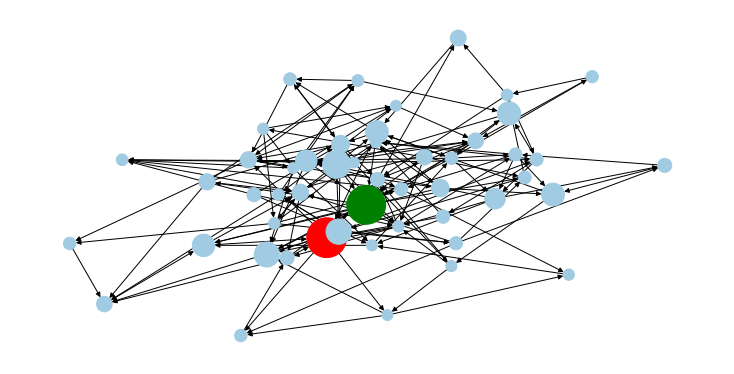

In [10]:
scores = score_nodes(rc, u, train_t)
colors, node_scores, best_nodes, fig = draw_orginal(rc, scores, 2)

In [11]:

A          = rc.res
tot = A.shape[0]
for i in range(tot): A[i,i] = 0
A          = (A != 0)*1
S          = DirectedGraph(A, lambda x: x)

worst_idxs = list(set(range(tot)).difference(set(best_nodes)))
print("Num in worst: {}\nNum in best: {}".format(len(worst_idxs), len(best_nodes)))
S.specialize(worst_idxs)

spec_rc = make_res_comp(S.A,res_params)
spec_r_0 = spec_rc.state_0
spec_rc.fit(train_t,u)
spec_score = score_nodes(spec_rc, u, train_t)

Num in worst: 48
Num in best: 2


IndexError: row index (70) out of bounds

/usr/local/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:652: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(marker_size) / 2


58 Nodes
48 In Base


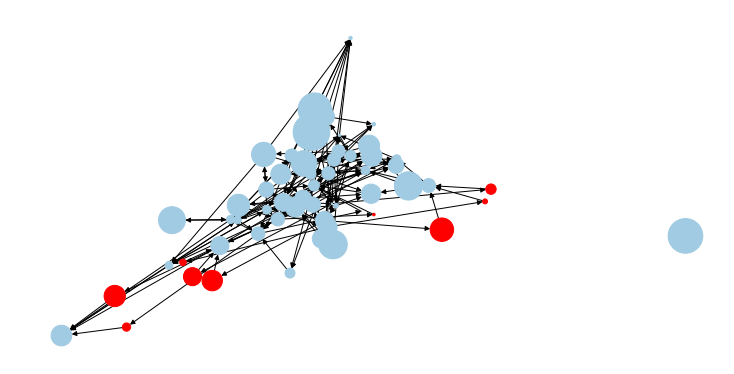

In [163]:
spec_color, spec_sozes, fig = draw_specialized(spec_rc, spec_score, S, colors)
print("{} Nodes".format(S.A.shape[0]))
print("{} In Base".format(np.sum(np.array(spec_color) == "#A0CBE2")))
plt.show()

In [164]:
list(map(lambda x: S.origination(x),list(range(58))))

[0,
 1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 49,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48]

In [152]:
best_nodes

[48, 2]

In [153]:
for i in best_nodes:
    print("In: {} \nOut: {}".format(np.sum(A[i,:]),np.sum(A[:,i])))

In: 2 
Out: 2
In: 3 
Out: 2


In [154]:
A[best_nodes,:][:,best_nodes]

array([[0, 0],
       [0, 0]])

### Future Work

1. Does "centrality" get passed to the "children" of important nodes
2. Do we have a limiting network if we keep specializing
    a. Top 3
    b. Random percent of top verticies
3. Randomly generating W_in and copying rows

In [70]:
A = np.array([[0,1,1,1,1],
              [1,0,0,0,0],
              [1,1,0,0,1],
              [0,0,1,0,1],
              [0,0,0,1,0]
             ])

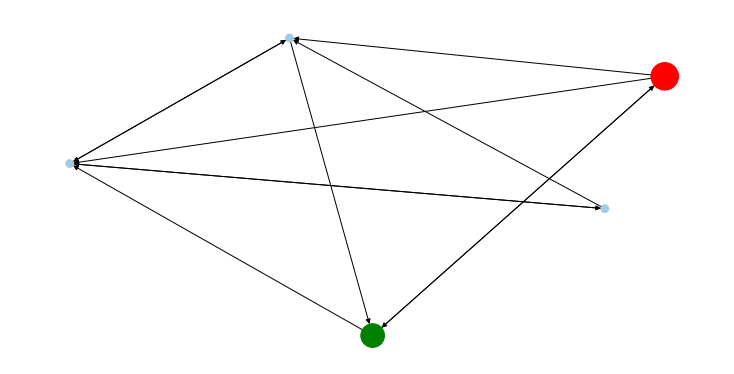

In [71]:
n = 5
scores = [.5,.5,.5,1,1.2]
G = nx.DiGraph(A.T)
best_nodes = [3,4]

# Make color map
colormap = ["#A0CBE2"] * n

COLORS = "grcmyk"
j= 0
for i in best_nodes:
    colormap[i] = COLORS[j]
    j+=1

sizes = (scores - np.mean(scores))/np.std(scores)
sizes = list(300*sizes + 300)
nx.draw(G, node_color=colormap, node_size=sizes)
# end

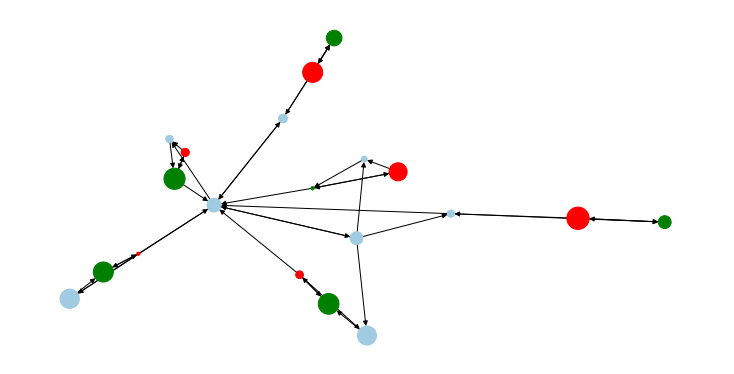

In [72]:
orig_colors = colormap
H = DirectedGraph(A,lambda x: x)
H.specialize_graph([0,1])
S = H.A
n = S.shape[0]
G = nx.DiGraph(S.T)

# Make color map
colormap = ["#A0CBE2"] * n
for i in range(n):
    colormap[i] = orig_colors[H.origination(i)]
# end

sizes = 500*np.random.rand(n)

nx.draw(G, node_color=colormap, node_size=sizes)
# end

In [169]:
A = 1*(np.random.rand(20,20) < .08)
for i in range(20): A[i,i] = 0;

In [204]:
A = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])


In [180]:
i = 12
print("Node: {}".format(i))
print("In-degree: {}".format(A.sum(axis=1)[i]))
print("Out-degree: {}".format(A.sum(axis=0)[i]))

Node: 12
In-degree: 5
Out-degree: 2


In [184]:
j = 15
print("Node: {}".format(i))
print("In-degree: {}".format(A.sum(axis=1)[i]))
print("Out-degree: {}".format(A.sum(axis=0)[i]))

Node: 15
In-degree: 2
Out-degree: 2


In [190]:
print("Connections between the nodes")
A[[i,j]][:,[i,j]]

Connections between the nodes


array([[0, 0],
       [0, 0]])

In [202]:
nodes = [12,15]
G = DirectedGraph(A, lambda x: x)
base = [i for i in range(20)]
base.remove(12)
base.remove(15)
G.specialize_graph(base)
print("Size of base: {}".format(len(base)))
print("Specialized size: {}".format(G.A.shape[0]))

Size of base: 18
Specialized size: 32


In [208]:
origin = list(map(lambda x: G.origination(x), list(range(32))))
print("Origins of all new nodes")
print(origin[18:])

Origins of all new nodes
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
